## Import Packages

In [1]:
# import data processing and visualisation libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import image processing libraries
import cv2
import skimage
from skimage.transform import resize

# import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
import os

## Load Data

In [2]:
#기본 Parameter 설정
BATCHSIZE = 25
imageSize = 60
target_dims = (imageSize, imageSize, 3)
num_classes = 11 #0~10까지 총 11개
train_len = 1534 #총 파일 수

train_dir = "../input/train/" #train 폴더 경로 지정(끝에 / 까지 쳐야함)

In [ ]:
from tqdm import tqdm #진행상황바 표시해주는 패키지

def get_data(folder, data_len): #data불러오는 함수
    
    X = np.empty((data_len, imageSize, imageSize, 3), dtype=np.float32)
    y = np.empty((data_len,), dtype=np.int)
    cnt = 0

    for folderName in os.listdir(folder): #기존 ASL alphabet용 코드를 약간 변형시켜줌
        if not folderName.startswith('.'):
            if folderName in ['00']: #label이 0부터 시작하게 하려고 0 사진 다운 받아둠
                label = 0
            elif folderName in ['01']:
                label = 1
            elif folderName in ['02']:
                label = 2
            elif folderName in ['03']:
                label = 3
            elif folderName in ['04']:
                label = 4
            elif folderName in ['05']:
                label = 5
            elif folderName in ['06']:
                label = 6
            elif folderName in ['07']:
                label = 7
            elif folderName in ['08']:
                label = 8
            elif folderName in ['09']:
                label = 9
            elif folderName in ['10']:
                label = 10
            for image_filename in tqdm(os.listdir(folder + folderName)):
              img_file = cv2.imread(folder + folderName + '/' + image_filename)
              if img_file is not None:
                img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3)) #image 사이즈 조정
                img_arr = np.asarray(img_file)
                
                X[cnt] = img_arr
                y[cnt] = label
                cnt += 1

    return X,y

In [ ]:
#X_train, y_train = get_data(train_dir,train_len)

In [3]:
#pickle 파일 load

import pickle

with open("../pickle/X_train_220602_imagesize_60_full","rb") as file :
    X_train=pickle.load(file)
    
with open("../pickle/y_train_220602_imagesize_60_full","rb") as file2 :
    y_train=pickle.load(file2)

In [4]:
#data 불러온 결과 shape출력(데이터수, imageSize, imageSize, 3) : get_data함수에서 설정해준 항목
print("The shape of X_train is : ", X_train.shape)
print("The shape of y_train is : ", y_train.shape)
print("The shape of one image is : ", X_train[0].shape)

The shape of X_train is :  (1534, 60, 60, 3)
The shape of y_train is :  (1534,)
The shape of one image is :  (60, 60, 3)


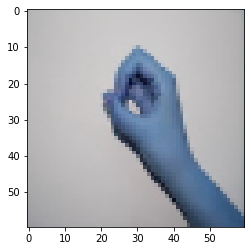

In [5]:
#예시로 이미지 출력
plt.imshow(X_train[0])
plt.show()

In [6]:
#Making copies of original data
X_data = X_train
y_data = y_train

In [7]:
#있는 데이터로 train, test split해주는 함수, test_size에서 비율 조정 가능
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3,random_state=42,stratify=y_data)

In [8]:
#train,test split된 것 출력해서 확인
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1073, 60, 60, 3)
(1073,)
(461, 60, 60, 3)
(461,)


## Modeling(VGG16)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dense, Flatten, BatchNormalization, Dropout

In [10]:
#Building model
model = Sequential()

#input shape는 위에 print(X_train.shape)로 확인한 차원을 적어야함
model.add(Conv2D(64, 3, strides= 1, padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(64, 3, strides= 1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPool2D((2,2), strides=2))

model.add(Conv2D(128, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(128, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPool2D((2, 2), strides=2))

model.add(Conv2D(256, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(256, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(256, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPool2D((2, 2), strides=2))

model.add(Conv2D(512, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(512, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(512, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPool2D((2, 2), strides=2))
model.add(MaxPool2D((2, 2), strides=2))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(11, activation='softmax')) #softmax함수 이용해서 총 11개 Class(0~10)분류

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 60, 60, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 60, 60, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 60, 60, 64)        0

In [11]:
#Early Stopping함수를 이용해서 patience수가 넘어가면 자동으로 Early Stopping되게 함
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [12]:
#Compiling
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
#Model fitting
model.fit(X_train, y_train,
          epochs=50,
          batch_size=BATCHSIZE,
          verbose=2,
          validation_data=(X_test, y_test),
          callbacks=[early_stop])

Epoch 1/50
43/43 - 96s - loss: 3.1615 - accuracy: 0.1100 - val_loss: 4.6129 - val_accuracy: 0.1540 - 96s/epoch - 2s/step
Epoch 2/50
43/43 - 91s - loss: 2.3533 - accuracy: 0.1389 - val_loss: 2.3710 - val_accuracy: 0.1540 - 91s/epoch - 2s/step
Epoch 3/50
43/43 - 91s - loss: 2.2974 - accuracy: 0.1500 - val_loss: 2.3809 - val_accuracy: 0.1540 - 91s/epoch - 2s/step
Epoch 4/50
43/43 - 92s - loss: 2.2636 - accuracy: 0.1696 - val_loss: 2.4265 - val_accuracy: 0.0889 - 92s/epoch - 2s/step
Epoch 5/50
43/43 - 92s - loss: 2.1829 - accuracy: 0.1901 - val_loss: 4.6890 - val_accuracy: 0.0889 - 92s/epoch - 2s/step
Epoch 6/50
43/43 - 91s - loss: 1.9902 - accuracy: 0.2265 - val_loss: 7.3804 - val_accuracy: 0.0889 - 91s/epoch - 2s/step
Epoch 7/50
43/43 - 92s - loss: 1.8775 - accuracy: 0.2768 - val_loss: 9.8847 - val_accuracy: 0.0889 - 92s/epoch - 2s/step


## Result

In [14]:
#Model metrics
metrics = pd.DataFrame(model.history.history)
print("The model metrics are")
metrics

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.161515,0.109972,4.612918,0.154013
1,2.353275,0.138863,2.371001,0.154013
2,2.297388,0.150047,2.380867,0.154013
3,2.263638,0.169618,2.426468,0.088937
4,2.182921,0.190121,4.689035,0.088937
5,1.990239,0.226468,7.380370,0.088937
6,1.877487,0.276794,9.884653,0.088937


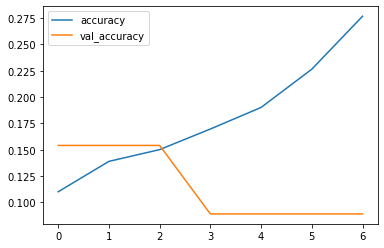

In [15]:
#저장된 accuracy 그래프로 출력
metrics[['accuracy','val_accuracy']].plot()
plt.show()

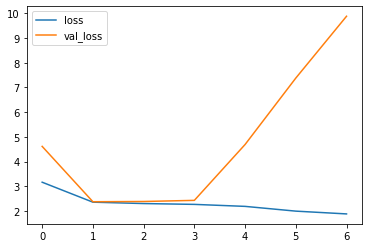

In [16]:
#저장된 loss 그래프로 출력
metrics[['loss','val_loss']].plot()
plt.show()

In [17]:
#Model evaluation
model.evaluate(X_test,y_test,verbose=0)

[9.884654998779297, 0.08893709629774094]

In [18]:
y_predictions=model.predict(X_test)
predictions=y_predictions.argmax(axis=1)

15/15 [==============================] - 8s 497ms/step


In [19]:
#Report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.00      0.00      0.00        41
           2       0.00      0.00      0.00        40
           3       0.00      0.00      0.00        41
           4       0.00      0.00      0.00        41
           5       0.00      0.00      0.00        42
           6       0.00      0.00      0.00        41
           7       0.09      1.00      0.16        41
           8       0.00      0.00      0.00        41
           9       0.00      0.00      0.00        41
          10       0.00      0.00      0.00        71

    accuracy                           0.09       461
   macro avg       0.01      0.09      0.01       461
weighted avg       0.01      0.09      0.01       461



C:\Users\HCIL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HCIL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HCIL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


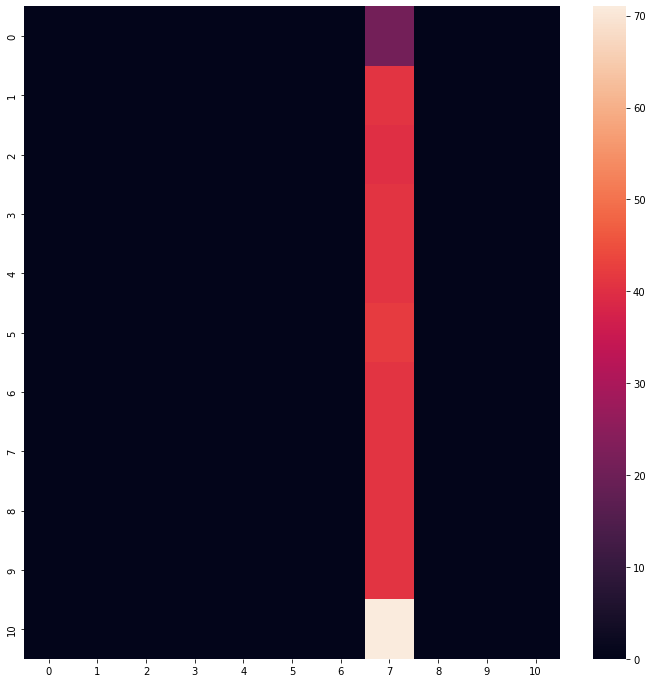

In [20]:
#Confusion matrix로 표시
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test,predictions))
plt.show()